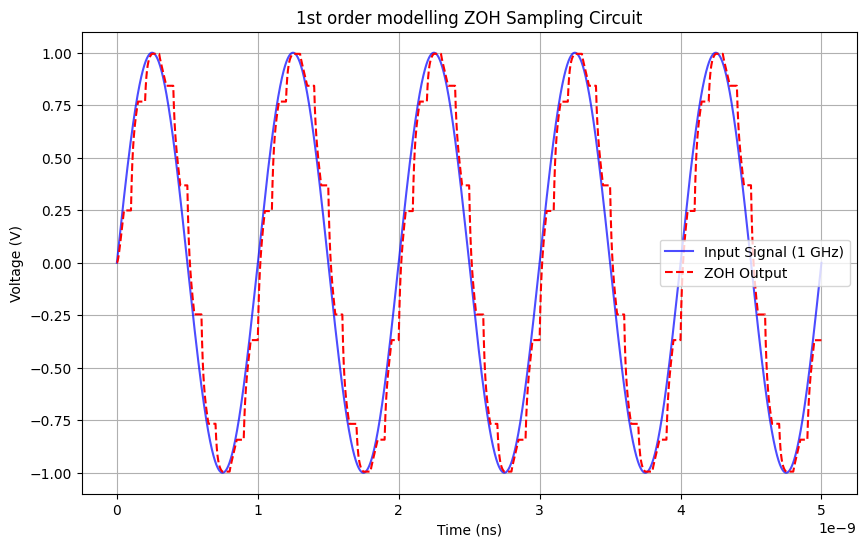

In [ ]:
#Q1 First order model of ZOH circuit

import numpy as np
import matplotlib.pyplot as plt
#------------------------------------------------------
#Inputs given
fin = 1e9 # 1GHz input frequency , 1ns time period
fs = 10e9
tau =  10e-12 # time constant of 10ps
#-------------------------------------------------------
#constants defined
t_max = 5e-9 # 5ns convers 5 cycles of input
A=1 # amplitude
dt = 1e-13 # time stamps at 0.1ps
#--------------------------------------------------------
t = np.arange(0,t_max,dt)
vin = A*np.sin(2*np.pi*fin*t) # input is sinusoid
vsampling = (np.sin(2*np.pi*fs*t)>0).astype(float) # vsampling is like square wave which is applied to switch

#--------------------------------------------------------
vout = np.zeros_like(vin)
hold_value = 0


for i in range(1,len(t)) :
  if vsampling[i] == 1 :
    #output voltage will be defined by the RC charging equation
    hold_value = hold_value * np.exp(-dt/tau) + vin[i] * (1-np.exp(-dt/tau))
    vout[i] = hold_value
  else :
    vout[i] = hold_value


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t , vin, label="Input Signal (1 GHz)", color='blue', alpha=0.7)
plt.plot(t , vout, label="ZOH Output", color='red', linestyle='--')
plt.xlabel("Time (ns)")
plt.ylabel("Voltage (V)")
plt.title("1st order modelling ZOH Sampling Circuit")
plt.legend()
plt.grid(True)
plt.show()

Variance of error : 0.0003473740748328054
Variance of quantization noise : 0.00034162351916808693


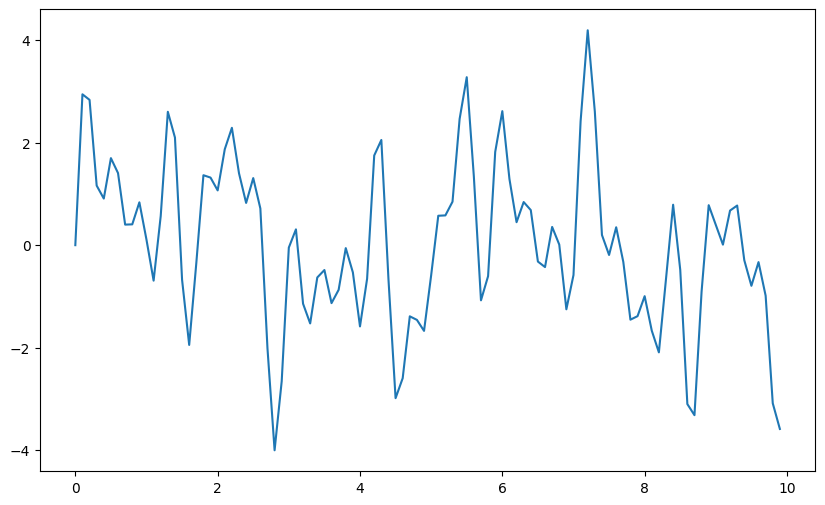

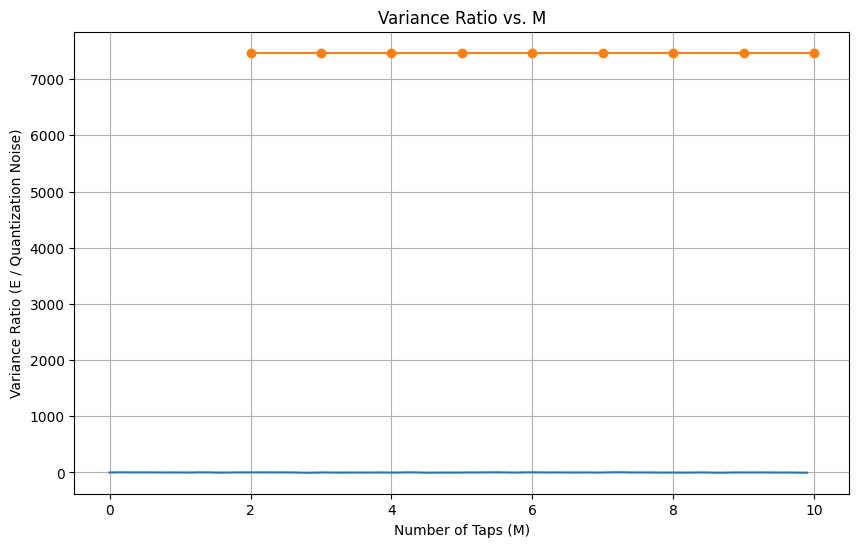

In [1]:
#Q3 Sampling Error Estimation

import numpy as np
import matplotlib.pyplot as plt

def generate_multitone(fs,f_tones,duration) :
  t = np.arange(0,duration,1/fs)
  signal = sum(np.sin(2*np.pi*f*t) for f in f_tones)
  return t,signal

f_tones = [0.2,0.58,1,1.7,2.4] # all frequencies in GHz
fs=10 # frequency in GHz
duration = 10

t, x = generate_multitone(fs,f_tones,duration)

plt.figure(figsize=(10, 6))
plt.plot(t,x)

#ADC Quantization

def quantize(signal, n_bits):
  q_levels = 2**n_bits
  q_step = (np.max(signal) - np.min(signal)) / (q_levels)
  quantized_signal = np.round(signal/q_step) * q_step
  return quantized_signal

nbits =7
quantized_x = quantize(x,nbits)

plt.figure(figsize=(10, 6))
plt.plot(t,quantized_x)


error = x-quantized_x
variance_error = np.var(error)
variance_quantization_noise = ((np.max(x)-np.min(x))**2) / (12 * (2**nbits)**2)

print(f"Variance of error : {variance_error}")
print(f"Variance of quantization noise : {variance_quantization_noise}")


from scipy.linalg import toeplitz

def fir_filter_least_squares(signal, M):
    # Constructing the Toeplitz matrix
    X = toeplitz(signal, np.zeros(M))
    X = X[:, :M]
    # Least Squares Solution
    h = np.linalg.pinv(X) @ signal
    estimated_error = X @ h
    return estimated_error

# Vary M from 2 to 10
M_values = range(2, 11)
variance_ratios = []

for M in M_values:
    estimated_error = fir_filter_least_squares(quantized_x, M)
    combined_error = error + estimated_error
    variance_ratio = np.var(combined_error) / variance_quantization_noise
    variance_ratios.append(variance_ratio)

# Plotting the ratio as M varies
plt.plot(M_values, variance_ratios, marker='o')
plt.title("Variance Ratio vs. M")
plt.xlabel("Number of Taps (M)")
plt.ylabel("Variance Ratio (E / Quantization Noise)")
plt.grid()
plt.show()

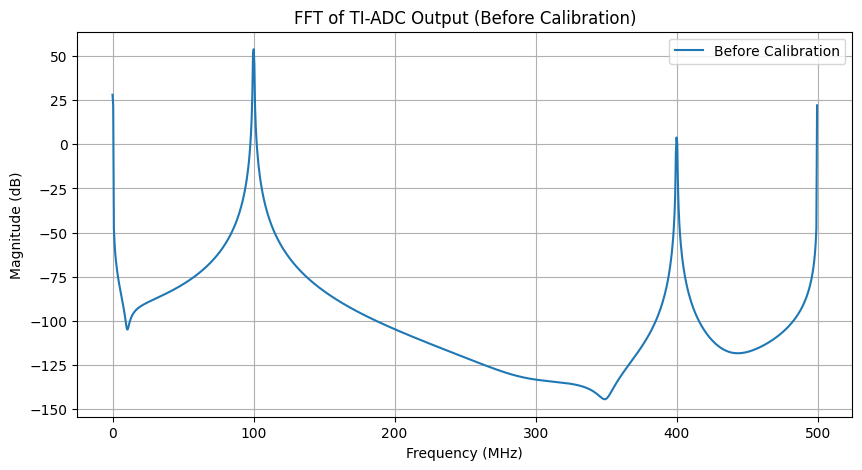

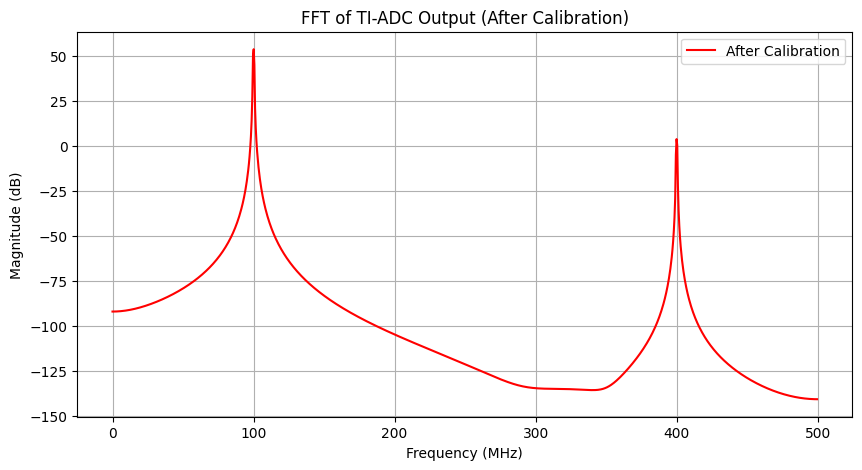

In [ ]:
#Prob-4 on Time Interleaved ADC
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz

# Simulation Parameters
fs = 1e9  # Sampling frequency (1 GHz)
f_signal = 100e6  # Signal frequency (100 MHz)
n_samples = 2048  # Number of samples

# Generate Time Axis
t = np.arange(n_samples) / fs

# Generate Input Signal
signal = np.sin(2 * np.pi * f_signal * t)

# Introduce Mismatches
time_skew = 10e-12  # 10 ps timing mismatch
offset_mismatch = 0.05  # 50 mV offset mismatch
bandwidth_mismatch = 0.05  # 5% bandwidth mismatch

# Simulate Two-Channel TI-ADC
adc1 = signal[::2]  # First ADC samples
adc2 = signal[1::2] + offset_mismatch  # Second ADC samples with offset

# Time Skew Effect (introducing delay in second ADC)
t2 = t[1::2] + time_skew
adc2 = np.sin(2 * np.pi * f_signal * t2) + offset_mismatch

# Combine TI-ADC Output
ti_adc_output = np.empty(n_samples)
ti_adc_output[::2] = adc1
ti_adc_output[1::2] = adc2

# Compute and Plot FFT
def compute_fft(signal, fs):
    fft_output = np.fft.fft(signal * np.hanning(len(signal)))
    freqs = np.fft.fftfreq(len(signal), 1/fs)
    return freqs[:len(signal)//2], 20 * np.log10(np.abs(fft_output[:len(signal)//2]))

freqs, spectrum = compute_fft(ti_adc_output, fs)
plt.figure(figsize=(10, 5))
plt.plot(freqs / 1e6, spectrum, label="Before Calibration")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")
plt.title("FFT of TI-ADC Output (Before Calibration)")
plt.legend()
plt.grid()
plt.show()

# Calibration (Offset and Time Mismatch Correction)
ti_adc_output[1::2] -= offset_mismatch  # Remove Offset

def delay_correct(signal, time_skew, fs):
    delay_samples = int(time_skew * fs)
    corrected_signal = np.roll(signal, -delay_samples)  # Shift to compensate delay
    return corrected_signal

ti_adc_output[1::2] = delay_correct(ti_adc_output[1::2], time_skew, fs)

# Compute FFT After Calibration
freqs, spectrum_calibrated = compute_fft(ti_adc_output, fs)
plt.figure(figsize=(10, 5))
plt.plot(freqs / 1e6, spectrum_calibrated, label="After Calibration", color='red')
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")
plt.title("FFT of TI-ADC Output (After Calibration)")
plt.legend()
plt.grid()
plt.show()
